# 0. IMPORTS

In [1]:
import pandas as pd
import PIL as pil
import numpy as np
import os
import tensorflow.keras as tfk
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
)


In [ ]:
!conda install -y gdown

In [ ]:
# DOWNLOADING IMAGES INTO KAGGLE
! gdown -q 1DzfEtmwEzxRiEuJcTEYSbr9WQDBgbZ5L
! unzip images.zip

# 1. LOAD AND PREPARE DATASET

In [2]:
# LOADING REFERENCE DATASET AND CLEANING THE PATHS
df_labels = pd.read_csv("/kaggle/input/cv-final-project/df_dates.csv")
df_labels["drive_path"] = [re.findall(r"(?<=\\).*$",x)[0] for x in df_labels.local_image_path]

In [3]:
# KEEP IMAGES OF BUILDINGS BUILT LATER THAN 1500
df_labels["drive_path"] = [re.findall(r"(?<=\\).*$",x)[0] for x in df_labels.local_image_path]


In [4]:
df_labels = df_labels[df_labels.date_int > 1500].reset_index(drop = True)

In [3]:
df_labels.shape

(9814, 12)

In [5]:
# ENCODING LABELS
label_gen_to_num = {df_labels.typology_gen.unique()[x] : x for x in range(len(df_labels.typology_gen.unique()))}
label_spe_to_num = {df_labels.typology_spe.unique()[x] : x for x in range(len(df_labels.typology_spe.unique()))}
df_labels["label_gen"] = df_labels.typology_gen.map(label_gen_to_num)
df_labels["label_spe"] = df_labels.typology_spe.map(label_spe_to_num)

In [6]:
# TRAIN TEST SPLIT
seed = 42
X = df_labels.drop(["label_gen","date_int"], axis = 1).copy()

labels = df_labels.label_gen
dates = df_labels.date_int

train_images, val_images, train_labels, val_labels, train_dates, val_dates = train_test_split(
    X, labels, dates, test_size=0.2, random_state=seed, stratify=labels
)

In [7]:
# HOLDING OUT SOME OBSERVATION FOR TESTING

val_images, test_images, val_labels, test_labels, val_dates, test_dates = train_test_split(
    val_images, val_labels, val_dates, test_size=0.1, random_state=seed, stratify=val_labels
)

In [8]:
# CONSTRUCT THE LABELS
train_image_paths = train_images.drive_path.tolist()
train_labels = tfk.utils.to_categorical(train_labels, num_classes=6)
train_dates = np.array(train_dates)

val_image_paths = val_images.drive_path.tolist()
val_labels = tfk.utils.to_categorical(val_labels, num_classes=6)
val_labels_dates = np.array(val_dates)

test_image_paths = test_images.drive_path.tolist()
test_labels = tfk.utils.to_categorical(test_labels, num_classes=6)
test_dates = np.array(test_dates)

In [9]:
# GET THE IMAGE PATH
train_image_paths = ["/kaggle/working/content/drive/My Drive/FINANCE_WITH_BIG_DATA/computer_vision_temp/images/" + x for x in train_image_paths]
val_image_paths = ["/kaggle/working/content/drive/My Drive/FINANCE_WITH_BIG_DATA/computer_vision_temp/images/" + x for x in val_image_paths]
test_image_paths = ["/kaggle/working/content/drive/My Drive/FINANCE_WITH_BIG_DATA/computer_vision_temp/images/" + x for x in test_image_paths]

In [10]:
# DIVIDE DATES BY 100 TO AVOID LARGE GRADIENTS
train_dates = train_dates / 100
val_dates = val_dates / 100
test_dates = test_dates / 100

In [11]:
def load_preprocess(image_path):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Normalize

    return image

In [12]:
# CHANGE SAVE = True to repeat the preprocessing
SAVE = False
if SAVE:
    X_train = np.array([load_preprocess(path) for path in train_image_paths]) # preprocess images for training
    X_val = np.array([load_preprocess(path) for path in val_image_paths]) # preprocess images for validation
    X_test = np.array([load_preprocess(path) for path in test_image_paths]) # preprocess images for testing

In [13]:
if SAVE:
    # Save the array in HDF5 format with compression
    with h5py.File('/kaggle/working/X_train.h5', 'w') as f:
        f.create_dataset('X_train', data=X_train, compression='gzip', compression_opts=9)
    
    with h5py.File('/kaggle/working/X_val.h5', 'w') as f:
        f.create_dataset('X_val', data=X_val, compression='gzip', compression_opts=9)
    
    with h5py.File('/kaggle/working/X_test.h5', 'w') as f:
        f.create_dataset('X_test', data=X_test, compression='gzip', compression_opts=9)

In [14]:
# TO LOAD IT AGAIN AFTER THE PREPROCESSED IMAGES HAVE BEEN DOWNLOADED
LOAD = True
if LOAD:
  with h5py.File('/kaggle/working/X_train.h5', 'r') as f:
      # Access the dataset (the array you saved)
      X_train = f['X_train'][:]

  with h5py.File('/kaggle/working//X_val.h5', 'r') as f:
    # Access the dataset (the array you saved)
    X_val = f['X_val'][:]

  with h5py.File('/kaggle/working/X_test.h5', 'r') as f:
    # Access the dataset (the array you saved)
    X_test = f['X_test'][:]


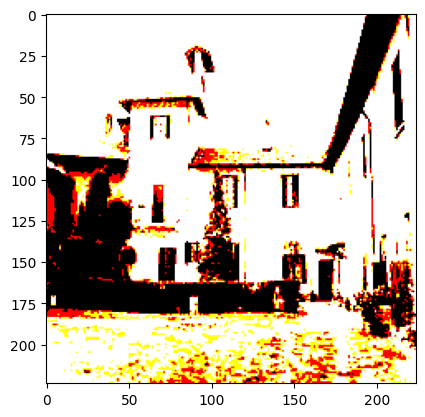

In [15]:
# testing to see some images
plt.imshow(X_train[67])

-------

# 2. RESNET

## 2.1 Training

In [ ]:
RETRAIN = False

In [16]:
# Load the ResNet50 base model without the top layer
resnet = tfk.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in resnet.layers:
   layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [105]:
#-------------- ARCHITECTURE ------------#
seed = 42
x = resnet.output
x = tfk.layers.Flatten()(x)
x = tfk.layers.BatchNormalization()(x)

# CLASS DENSE LAYERS
class_outputs = tfk.layers.Dense(256,activation='relu')(x)
class_outputs = tfk.layers.BatchNormalization()(class_outputs)
class_outputs = tfk.layers.Dropout(0.5)(class_outputs)
class_outputs = tfk.layers.Dense(128,activation='relu')(class_outputs)
class_outputs = tfk.layers.BatchNormalization()(class_outputs)
class_outputs = tfk.layers.Dropout(0.5)(class_outputs)
class_outputs = tfk.layers.Dense(6,activation='softmax', name = "classes")(class_outputs)

# REGRESSION DENSE LAYERS
regression_outputs = tfk.layers.Dense(256,activation='relu')(x)
regression_outputs = tfk.layers.BatchNormalization()(regression_outputs)
regression_outputs = tfk.layers.Dropout(0.5)(regression_outputs)
regression_outputs = tfk.layers.Dense(128,activation='relu')(x)
regression_outputs = tfk.layers.BatchNormalization()(regression_outputs)
regression_outputs = tfk.layers.Dropout(0.5, seed=seed)(regression_outputs)
regression_outputs = tfk.layers.Dense(1,activation='linear', name = "regression")(regression_outputs)

# OPTIMIZER, LOSSES
optimizer = tfk.optimizers.RMSprop(0.005)
class_loss = tfk.losses.CategoricalCrossentropy()
reg_loss = tfk.losses.MeanSquaredError()
class_regression_model = tfk.Model(inputs=resnet.input, outputs=[class_outputs, regression_outputs], name='class_reg_model')
class_regression_model.compile(loss={"classes": class_loss, "regression": reg_loss}, optimizer=optimizer,metrics={"classes": ["accuracy"], "regression": ["mae"]})    # MAE for regression head

In [106]:
if RETRAIN:
    checkpoint_filepath = "/kaggle/working/checkpoint_run.model2.keras"
    
    earlystopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_delta=1e-6)
    checkpoints = tfk.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_regression_mae',mode='min',save_best_only=True, verbose = 1)
    
    
    callbacks = [earlystopping, reduce_lr, checkpoints]
    
    history = class_regression_model.fit(x = X_train, y = [train_labels, train_dates],
                                         batch_size = 64,
                                         epochs = 50,
                                         verbose = 2,
    
                                         #VALIDATION DATA
                                         validation_data = (X_val,[val_labels, val_dates]),
    
                                         # EARLY STOPPING,LR ADJUSTMENTS, CHECKPOINTS
                                         callbacks = callbacks
                                         #
    ).history
    
    class_regression_model.save("/kaggle/working/class_regression_model2.keras")

Epoch 1/50

Epoch 1: val_regression_mae improved from inf to 4.79282, saving model to /kaggle/working/checkpoint_run.model2.keras
107/107 - 71s - 660ms/step - classes_accuracy: 0.6699 - loss: 111.9623 - regression_mae: 8.7421 - val_classes_accuracy: 0.7362 - val_loss: 35.2559 - val_regression_mae: 4.7928 - learning_rate: 0.0050
Epoch 2/50

Epoch 2: val_regression_mae improved from 4.79282 to 1.39610, saving model to /kaggle/working/checkpoint_run.model2.keras
107/107 - 28s - 258ms/step - classes_accuracy: 0.8059 - loss: 13.3989 - regression_mae: 2.7474 - val_classes_accuracy: 0.7609 - val_loss: 3.8950 - val_regression_mae: 1.3961 - learning_rate: 0.0050
Epoch 3/50

Epoch 3: val_regression_mae improved from 1.39610 to 1.15566, saving model to /kaggle/working/checkpoint_run.model2.keras
107/107 - 27s - 251ms/step - classes_accuracy: 0.8764 - loss: 5.8011 - regression_mae: 1.8395 - val_classes_accuracy: 0.7615 - val_loss: 2.9210 - val_regression_mae: 1.1557 - learning_rate: 0.0050
Epoch 4

## 2.2 Tuning

In [109]:
# RELOAD MODEL
del class_regression_model
# Load the model
best_model = load_model('class_regression_model2.keras')

In [114]:
# UNFREEZE RESNET, FREEZE MLP
trainable = True
for layer in best_model.layers:
    if re.search(r"flatten",layer.name):
        trainable = False
    layer.trainable = trainable



In [116]:
# NEW PARAMS
optimizer_low = tfk.optimizers.RMSprop(2e-5)
class_loss = tfk.losses.CategoricalCrossentropy()
reg_loss = tfk.losses.MeanSquaredError()
best_model.compile(loss={"classes": class_loss, "regression": reg_loss}, optimizer=optimizer_low,metrics={"classes": ["accuracy"], "regression": ["mae"]})    # MAE for regression head

In [117]:
if RETRAIN:
    checkpoint_filepath = "/kaggle/working/checkpoint.model_finetuned2.keras"
    
    earlystopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoints = tfk.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_regression_mae',mode='min',save_best_only=True, verbose = 1)
    
    
    callbacks = [earlystopping, checkpoints]
    
    history = best_model.fit(x = X_train, y = [train_labels, train_dates],
                                         batch_size = 16,
                                         epochs = 50,
                                         verbose = 2,
    
                                         #VALIDATION DATA
                                         validation_data = (X_val,[val_labels, val_dates]),
    
                                         # EARLY STOPPING,LR ADJUSTMENTS, CHECKPOINTS
                                         callbacks = callbacks
                                         #
    ).history
    best_model.save("/kaggle/working/best_model_finetuned2.keras")



Epoch 1/50

Epoch 1: val_regression_mae improved from inf to 0.93822, saving model to /kaggle/working/checkpoint.model_finetuned2.keras
428/428 - 151s - 353ms/step - classes_accuracy: 0.7883 - loss: 4.2944 - regression_mae: 1.4893 - val_classes_accuracy: 0.7453 - val_loss: 2.6716 - val_regression_mae: 0.9382
Epoch 2/50

Epoch 2: val_regression_mae improved from 0.93822 to 0.91630, saving model to /kaggle/working/checkpoint.model_finetuned2.keras
428/428 - 78s - 183ms/step - classes_accuracy: 0.8933 - loss: 3.5059 - regression_mae: 1.4138 - val_classes_accuracy: 0.7524 - val_loss: 2.4446 - val_regression_mae: 0.9163
Epoch 3/50

Epoch 3: val_regression_mae improved from 0.91630 to 0.90093, saving model to /kaggle/working/checkpoint.model_finetuned2.keras
428/428 - 78s - 183ms/step - classes_accuracy: 0.9296 - loss: 3.1379 - regression_mae: 1.3793 - val_classes_accuracy: 0.7492 - val_loss: 2.3947 - val_regression_mae: 0.9009
Epoch 4/50

Epoch 4: val_regression_mae improved from 0.90093 to

--------

# 3. EVALUATION

## 3.1 Fine-tuned Model

In [19]:
# LOAD MODEL
best_model = tfk.models.load_model("/kaggle/working/best_model_finetuned2.keras")

In [44]:
test_predictions = best_model.predict(X_test, verbose=0)
classification_predictions_test = np.argmax(test_predictions[0], axis=1)
regression_predictions_test = test_predictions[1]

In [45]:
val_predictions = best_model.predict(X_val, verbose=0)
classification_predictions_val = np.argmax(val_predictions[0], axis=1)
regression_predictions_val = val_predictions[1]

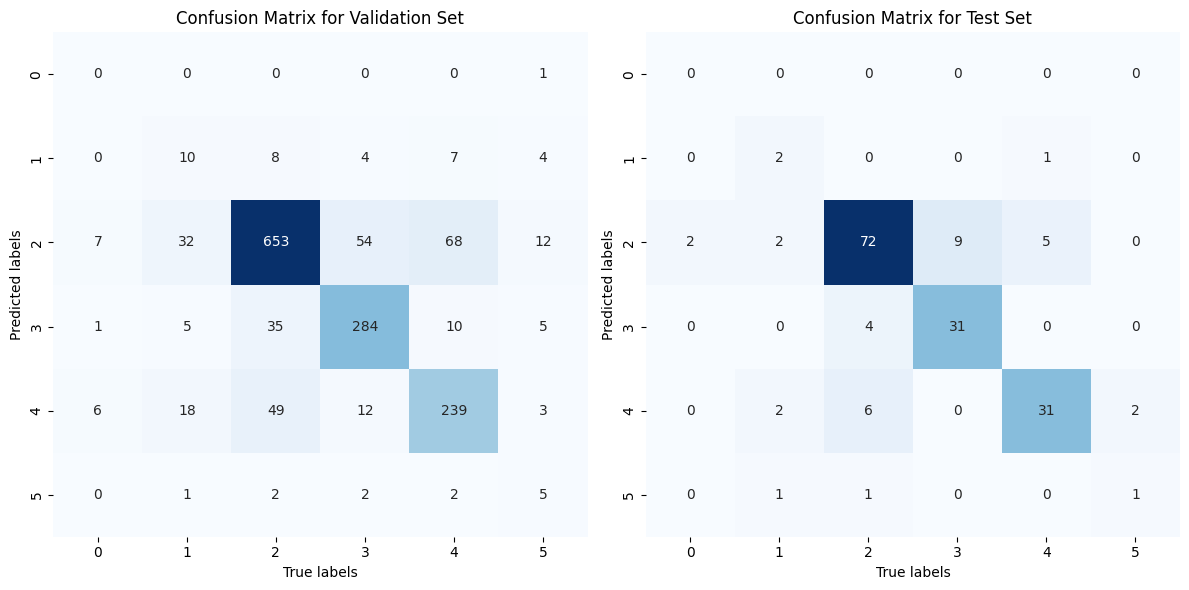

In [28]:
# --------- CONFUSION MATRIX ---------- #

# Retrieve true labels from the validation set
test_true_labels = np.argmax(test_labels, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)

# Compute the confusion matrix for the validation set
cm_val = confusion_matrix(val_true_labels, classification_predictions_val)

# Compute the confusion matrix for the test set
cm_test = confusion_matrix(test_true_labels, classification_predictions_test)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the validation confusion matrix
sns.heatmap(cm_val.T, fmt='d', cmap='Blues', annot=True, cbar=False, ax=axes[0])
axes[0].set_xlabel('True labels')
axes[0].set_ylabel('Predicted labels')
axes[0].set_title('Confusion Matrix for Validation Set')

# Plot the test confusion matrix
sns.heatmap(cm_test.T, fmt='d', cmap='Blues', annot=True, cbar=False, ax=axes[1])
axes[1].set_xlabel('True labels')
axes[1].set_ylabel('Predicted labels')
axes[1].set_title('Confusion Matrix for Test Set')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Show the plot
plt.show()

### MAE

In [48]:
mae_val = mean_absolute_error(val_dates, regression_predictions_val)

# Display the result
print(f'Mean Absolute Error (MAE) for the test set: {mae_val * 100:.2f} years')

Mean Absolute Error (MAE) for the test set: 83.95 years


In [49]:
mae_test = mean_absolute_error(test_dates, regression_predictions_test)

# Display the result
print(f'Mean Absolute Error (MAE) for the test set: {mae_test * 100:.2f} years')

Mean Absolute Error (MAE) for the test set: 87.08 years


In [30]:
mean_test_date = np.mean(test_dates)
mean_test = np.full_like(test_dates, mean_test_date)

In [31]:
mean_mae_test = mean_absolute_error(test_dates, mean_test)
print(f"by predicting using only the mean, we get Mean Absolute Error (MAE): {mean_mae_test* 100:.2f} years")

by predicting using only the mean, we get Mean Absolute Error (MAE): 105.81 years


# CLASSIFICATION

In [34]:
# accuracy on the validation set
val_accuracy = accuracy_score(val_true_labels, classification_predictions_val)
print(f'Accuracy score on validation set: {round(val_accuracy*100, 2)}')

# precision on the validation set
val_precision = precision_score(val_true_labels, classification_predictions_val, average='macro')
print(f'Precision score on validation set: {round(val_precision*100, 2)}')

# recall on the validation set
val_recall = recall_score(val_true_labels, classification_predictions_val, average='macro')
print(f'Recall score on validation set: {round(val_recall*100, 2)}')

# F1 score on the validation set
val_f1 = f1_score(val_true_labels, classification_predictions_val, average='macro')
print(f'F1 score on validation set: {round(val_f1*100, 2)}')

Accuracy score on validation set: 77.39
Precision score on validation set: 51.27
Recall score on validation set: 45.39
F1 score on validation set: 46.97


In [36]:
# accuracy on the validation set
test_accuracy = accuracy_score(test_true_labels, classification_predictions_test)
print(f'Accuracy score on validation set: {round(test_accuracy*100, 2)}')

# precision on the validation set
test_precision = precision_score(test_true_labels, classification_predictions_test, average='macro')
print(f'Precision score on validation set: {round(test_precision*100, 2)}')

# recall on the validation set
test_recall = recall_score(test_true_labels, classification_predictions_test, average='macro')
print(f'Recall score on validation set: {round(test_recall*100, 2)}')

# F1 score on the validation set
test_f1 = f1_score(test_true_labels, classification_predictions_test, average='macro')
print(f'F1 score on validation set: {round(test_f1*100, 2)}')

Accuracy score on validation set: 79.65
Precision score on validation set: 57.36
Recall score on validation set: 51.66
F1 score on validation set: 53.12


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.2 Only trained model

In [37]:
base_model = tfk.models.load_model("/kaggle/working/class_regression_model2.keras")

In [38]:
test_predictions_base = base_model.predict(X_test, verbose=0)
classification_predictions_test_base = np.argmax(test_predictions_base[0], axis=1)
regression_predictions_test_base = test_predictions_base[1]

In [39]:
val_predictions_base = base_model.predict(X_val, verbose=0)
classification_predictions_val_base = np.argmax(val_predictions_base[0], axis=1)
regression_predictions_val_base = val_predictions_base[1]

### MAE

In [50]:
mae_val = mean_absolute_error(val_dates, regression_predictions_val_base)

# Display the result
print(f'Mean Absolute Error (MAE) for the test set: {mae_val * 100:.2f} years')

Mean Absolute Error (MAE) for the test set: 91.20 years


In [51]:
mae_test = mean_absolute_error(test_dates, regression_predictions_test_base)

# Display the result
print(f'Mean Absolute Error (MAE) for the test set: {mae_test * 100:.2f} years')

Mean Absolute Error (MAE) for the test set: 92.41 years


### CLASSIFICATION

In [40]:
# accuracy on the validation set
val_accuracy_base = accuracy_score(val_true_labels, classification_predictions_val_base)
print(f'Accuracy score on validation set: {round(val_accuracy_base*100, 2)}')

# precision on the validation set
val_precision_base = precision_score(val_true_labels, classification_predictions_val_base, average='macro')
print(f'Precision score on validation set: {round(val_precision_base*100, 2)}')

# recall on the validation set
val_recall_base = recall_score(val_true_labels, classification_predictions_val_base, average='macro')
print(f'Recall score on validation set: {round(val_recall_base*100, 2)}')

# F1 score on the validation set
val_f1_base = f1_score(val_true_labels, classification_predictions_val_base, average='macro')
print(f'F1 score on validation set: {round(val_f1_base*100, 2)}')

Accuracy score on validation set: 76.41
Precision score on validation set: 51.65
Recall score on validation set: 43.94
F1 score on validation set: 45.84


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
# accuracy on the validation set
test_accuracy_base = accuracy_score(test_true_labels, classification_predictions_test_base)
print(f'Accuracy score on test set: {round(test_accuracy_base*100, 2)}')

# precision on the validation set
test_precision_base = precision_score(test_true_labels, classification_predictions_test_base, average='macro')
print(f'Precision score on test set: {round(test_precision_base*100, 2)}')

# recall on the validation set
test_recall_base = recall_score(test_true_labels, classification_predictions_test_base, average='macro')
print(f'Recall score on test set: {round(test_recall_base*100, 2)}')

# F1 score on the validation set
test_f1_base = f1_score(test_true_labels, classification_predictions_test_base, average='macro')
print(f'F1 score on test set: {round(test_f1_base*100, 2)}')

Accuracy score on test set: 75.58
Precision score on test set: 54.09
Recall score on test set: 45.71
F1 score on test set: 47.74


----------

# 4. GRAD-CAM

In [75]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [54]:
# DEFINE PATHS FOR THE IMAGES
paths = test_images.sample(n = 9, random_state = seed).drive_path.tolist()

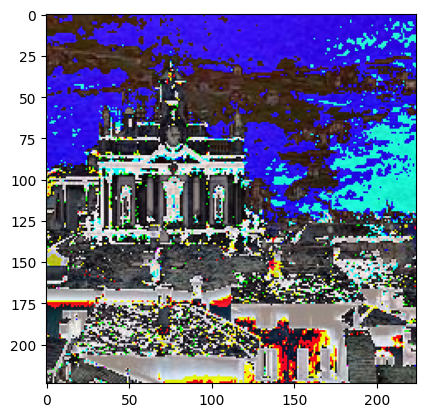

In [55]:
# EXPLORING THE RESNET PROCESSED IMAGE 
test_image = paths[1]
path = "/kaggle/working/content/drive/My Drive/FINANCE_WITH_BIG_DATA/computer_vision_temp/images/" + test_image
image = load_preprocess(path)
plt.imshow(image)
image = np.expand_dims(image, axis = 0)
image = tf.cast(image, dtype = tf.float32)

In [56]:
def make_gradcam_heatmap(img_array, task):

    
    # IF CLASSIFICATION COMPITE THE GRADIENT BY GETTING PRED INDEX
    if task == "classification":
        grad_model = tf.keras.models.Model(
        inputs=best_model.input,
        outputs=[best_model.get_layer("conv5_block3_out").output, best_model.get_layer("classes").output]
        )
            
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            pred_index = tf.argmax(preds[0])
            channel = preds[:, pred_index]
            
            
    # IN CASE OF REGRESSION WE JUST HAVE ONE PREDICTION
    elif task == "regression":
        grad_model = tf.keras.models.Model(
        inputs=best_model.input,
        outputs=[best_model.get_layer("conv5_block3_out").output, best_model.get_layer("regression").output]
        )
            
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            channel = preds[0]

    else:
        raise ValueError("Select a task between regression and classification")
        
    # Compute gradients
    grads = tape.gradient(channel, last_conv_layer_output)
    # Diagnostic check
    if grads is None:
        raise ValueError("Gradients are None. Check the model structure and inputs.")
        
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [57]:
import matplotlib.cm as cm

def save_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.7):
    # Load the original image
    img = tfk.utils.load_img(img_path)
    img = tfk.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.utils.array_to_img(superimposed_img)
    return superimposed_img


/tmp/ipykernel_23/1880928668.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


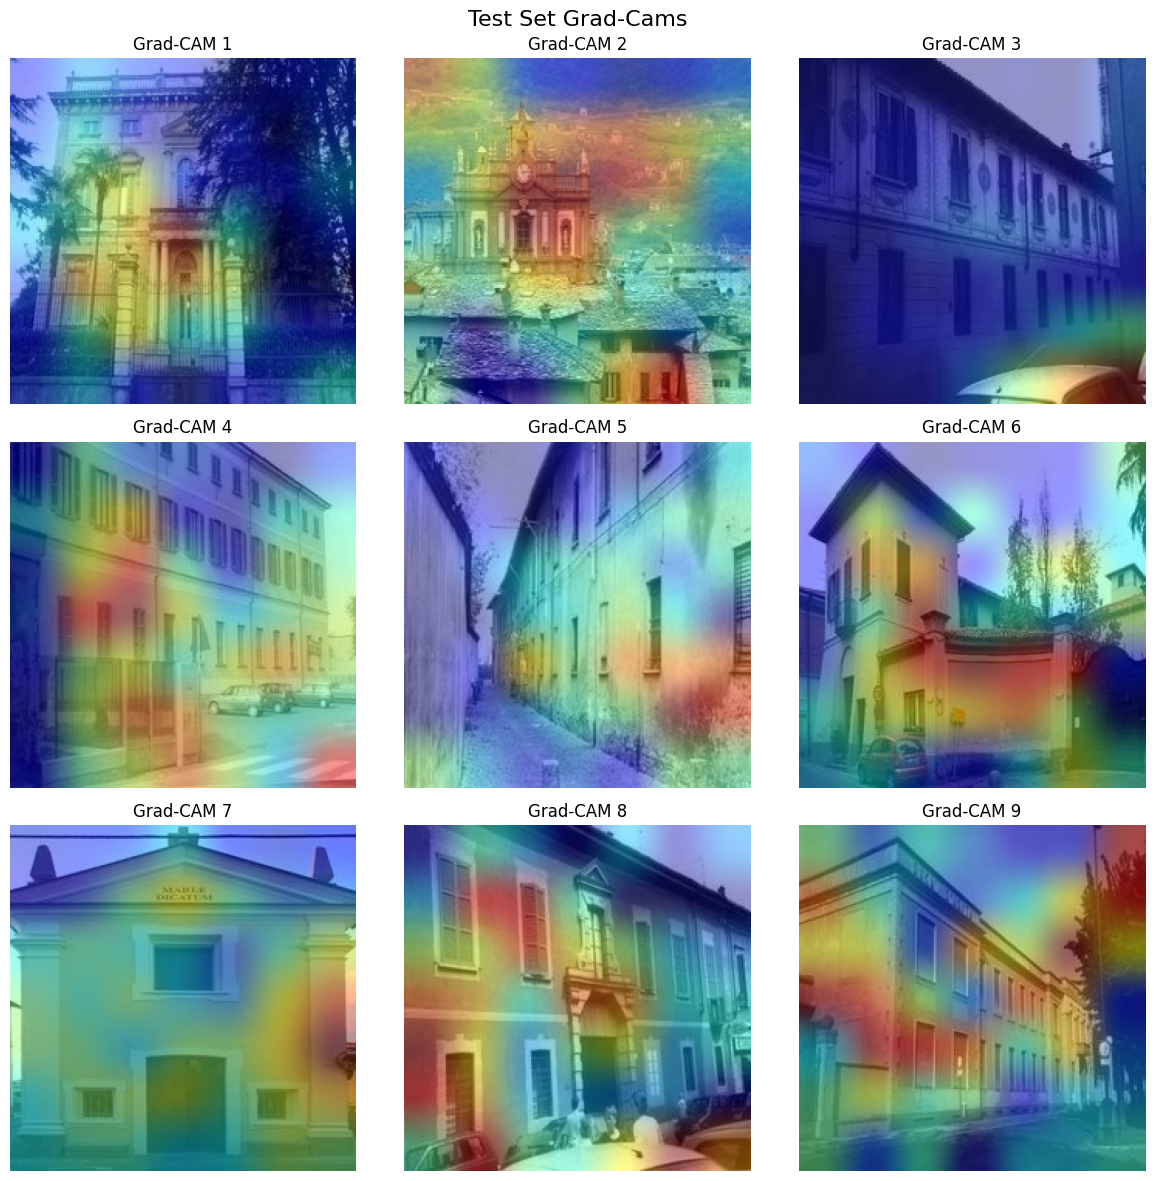

In [59]:
paths_complete = ["/kaggle/working/content/drive/My Drive/FINANCE_WITH_BIG_DATA/computer_vision_temp/images/" + path for path in paths]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Loop through each subplot and each image path
for i, ax in enumerate(axes.flat):
    # Load the image from the path
    
    image = load_preprocess(paths_complete[i])
    image = np.expand_dims(image, axis = 0)
    image = tf.cast(image, dtype = tf.float32)
    heatmap = make_gradcam_heatmap(image, "classification")

    
    # Display the image
    ax.imshow(save_gradcam(paths_complete[i], heatmap))
    
    # Set the title for each subplot (optional)
    ax.set_title(f'Grad-CAM {i+1}')
    
    # Hide axis ticks
    ax.axis('off')

# Add a title to the entire figure
fig.suptitle('Test Set Grad-Cams', fontsize=16)

# Adjust layout to prevent overlapping subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
image = load_preprocess(paths_complete[0])
image = np.expand_dims(image, axis = 0)
image = tf.cast(image, dtype = tf.float32)
heatmap = make_gradcam_heatmap(image, "classification")


map_report = save_gradcam(paths_complete[0], heatmap)
map_report.save("/kaggle/working/map_report2.jpg")